In [35]:
import torch
from torchviz import make_dot

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

import os
os.environ["OMP_NUM_THREADS"] = "4"

class PredictiveCoding(nn.Module):
    def __init__(
        self,
        layer_dims=[784, 100, 10],
        activation_type="sigmoid",
        bias=False,
    ):
        super().__init__()

        self.layer_dims = layer_dims
        self.num_layers = len(self.layer_dims)
        self.activation_type = activation_type
        self.bias = bias

        # Create linear layers using a ModuleList
        self.layers = nn.ModuleList()
        self.layer_norms = nn.ModuleList()
        for i in range(len(self.layer_dims) - 1):
            layer = nn.Linear(self.layer_dims[i], self.layer_dims[i + 1], bias=bias)
            nn.init.xavier_uniform_(layer.weight)  # Xavier initialization
            self.layers.append(layer)


        self._set_activation()
        self.softmax = nn.Softmax(dim=1)
        self.E = 0  
        self.mu = nn.ParameterList([nn.Parameter(torch.zeros(1, dim), requires_grad=(i not in [0, len(layer_dims) - 1])) for i, dim in enumerate(layer_dims)])
        self.error = [torch.zeros(1, dim) for dim in layer_dims]


    def _set_activation(self):
        # Set activation function
        if self.activation_type.lower() == "sigmoid":
            self.activation = nn.Sigmoid()
        elif self.activation_type.lower() == "tanh":
            self.activation = nn.Tanh()
        elif self.activation_type.lower() == "relu":
            self.activation = nn.ReLU()
        elif self.activation_type.lower() == "identity":
            self.activation = nn.Identity()
        else:
            raise NotImplementedError(f"Activation type '{self.activation_type}' is not recognized.")

    def clamp_input(self, input):
        # Explicitly set the first layer's mu to the input tensor
        self.mu[0].data = input.clone().detach().to(device)

    def clamp_output(self, output):
        # Explicitly set the last layer's mu to the output (target) tensor
        self.mu[-1].data = output.clone().detach().to(device)

    def compute_error(self):
        for l in range(1, len(self.mu)):
            layer_output = self.layers[l-1](self.activation((self.mu[l-1])))
            # variance = torch.var(self.mu[l], dim=0, keepdim=True)  # Compute variance
            self.error[l] = (self.mu[l] - layer_output) #/ torch.sqrt(variance + 1e-8)  # Add small value to avoid division by zero

        batch_size = self.mu[0].shape[0]
        self.E = 128*torch.sum(torch.stack([torch.sum(0.5 * error ** 2)/batch_size for error in self.error]))
        return self.E

    def label_pred(self, x):
        # Forward pass through the network
        for i, layer in enumerate(self.layers):
            x = layer(self.activation(x))
        return self.softmax(x)


def get_optimizer(parameters, optimizer_type, lr):
    if optimizer_type == "sgd":
        return optim.SGD(parameters, lr=lr)
    elif optimizer_type == "adam":
        return optim.Adam(parameters, lr=lr)
    elif optimizer_type == "adamw":
        return optim.AdamW(parameters, lr=lr)
    else:
        raise ValueError(f"Optimizer '{optimizer_type}' is not supported.")
    


def train_model(model, train_loader, T=3, device="cpu", weight_optimizer_type = "sgd", mu_optimizer_type = "sgd", learning_rate=0.003):

    total_energy = 0
    weight_optimizer = get_optimizer(
        (param for layer in model.layers for param in layer.parameters()), 
        weight_optimizer_type, 
        lr=learning_rate
    )

    for batch_idx, (data, target) in tqdm(enumerate(train_loader), desc="Training Batches", total=len(train_loader)):

        input_pattern = data.view(data.size(0), -1).to(device)
        target_pattern =  torch.nn.functional.one_hot(target, num_classes=10).float().to(device)


        batch_size = data.size(0)
        model.mu = nn.ParameterList([nn.Parameter(torch.zeros(batch_size, dim).to(device), requires_grad=(i not in [0, len(model.layer_dims) - 1])) for i, dim in enumerate(model.layer_dims)])
        model.error = [torch.zeros(batch_size, dim).to(device) for dim in model.layer_dims]
        model.clamp_input(input_pattern)
        model.clamp_output(target_pattern)


        mu_optimizer = get_optimizer(model.mu.parameters(),mu_optimizer_type,lr = 0.2)

        for t in range(T):
            energy = model.compute_error()
            # print(f"Batch {t}, Energy: {energy:.4f}")
            mu_optimizer.zero_grad()
            energy.backward()
            mu_optimizer.step()
        
        energy = model.compute_error()

        weight_optimizer.zero_grad()
        energy.backward()
        weight_optimizer.step()

        energy = model.compute_error()

        total_energy += energy
        
    total_energy /= len(train_loader)
    del model.mu, model.error, mu_optimizer  
    tqdm.write(f"Total Energy: {total_energy:.4f}")





import torch.nn.functional as F


def evaluate_model(model, test_loader, device="cpu", prev_output=None):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    cosine_similarities = []

    batch_index = 0  # To keep track of the current batch index

    with torch.no_grad():  # No need to compute gradients for evaluation
        for data, target in test_loader:
            input_pattern = data.view(data.size(0), -1).to(device)
            target = target.to(device)
            batch_size = data.size(0)
            
            output = model.label_pred(input_pattern)
            _, predicted = torch.max(output, 1)
            
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            if prev_output is not None:
                # Slice the relevant part of prev_output for the current batch
                prev_output_batch = prev_output[batch_index:batch_index + batch_size].to(device)
                
                # Convert target to one-hot vectors
                target_one_hot = F.one_hot(target, num_classes=output.size(1)).float()
                
                # Compute cosine similarity
                prev_diff = target_one_hot - prev_output_batch
                current_diff = target_one_hot - output
                cosine_similarity = F.cosine_similarity(prev_diff, current_diff, dim=1).mean().item()
                cosine_similarities.append(cosine_similarity)
            
            # Update the batch index
            batch_index += batch_size
            
            # Save the new output for future comparison
            if prev_output is None:
                prev_output = output.clone().detach()
            else:
                prev_output[batch_index - batch_size:batch_index] = output.clone().detach()
    
    accuracy = 100.0 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

    if cosine_similarities:
        avg_cosine_similarity = sum(cosine_similarities) / len(cosine_similarities)
        print(f'Average Cosine Similarity: {avg_cosine_similarity:.4f}')

    return prev_output


# Usage example (assuming you have defined `model`, `test_loader`, and `prev_output`):
# evaluate_model(model, test_loader, prev_output, device="cpu")

def get_output(model, test_loader, device="cpu"):
    model.eval()  # Set the model to evaluation mode
    outputs = []

    with torch.no_grad():  # No need to compute gradients for evaluation
        for data, _ in test_loader:
            input_pattern = data.view(data.size(0), -1).to(device)
            output = model.label_pred(input_pattern)
            outputs.append(output.clone().detach())

    # Concatenate all outputs into a single tensor
    final_output = torch.cat(outputs, dim=0)
    print(final_output.shape)
    return final_output


if __name__ == "__main__":

    # accuracy: 95.5% weight_optimizer: adamw, num_T: 60, learning_rate: 0.001 

    # Parameters
    batch_size = 128

    layer_dims=[784, 256, 128, 10]
    num_epochs = 20
    num_T = 60 # iteratioins of relaxation loop

    mu_optimizer_type = "sgd" # Options: "sgd", "adam", "adamw"
    weight_optimizer_type = "adamw" # Options: "sgd", "adam", "adamw"
    learning_rate = 0.001 # learning rate for weight optimizer, learning rate for mu optimizer is set to 0.1

    activation_type = "relu" # Options: "sigmoid", "tanh", "relu", "identity"
    bias = True

    use_gpu = False # might not be faster on GPU due to small network size


    # Data loaders
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = PredictiveCoding(layer_dims=layer_dims, activation_type=activation_type, bias=bias) 

    if use_gpu:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    else:
        device = torch.device("cpu")
    print(f"Using device: {device}")
    model.to(device)

    prev_output = get_output(model, test_loader, device=device) # Get the initial output    

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        train_model(model, train_loader, T = num_T, device = device, weight_optimizer_type=weight_optimizer_type, mu_optimizer_type = mu_optimizer_type, learning_rate = learning_rate)
        evaluate_model(model, test_loader, prev_output=prev_output, device=device)

    


Using device: cpu
torch.Size([10000, 10])
Epoch 1/20


Training Batches:   4%|▎         | 17/469 [00:18<08:06,  1.08s/it]


KeyboardInterrupt: 

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import torch.nn.functional as F

# Define the simple feedforward neural network
class SimpleNN(nn.Module):
    def __init__(self, layer_dims=[784, 100, 10], activation_type="relu", bias=True):
        super(SimpleNN, self).__init__()
        self.layer_dims = layer_dims
        self.activation_type = activation_type
        self.bias = bias

        # Create linear layers using a ModuleList
        self.layers = nn.ModuleList()
        for i in range(len(self.layer_dims) - 1):
            layer = nn.Linear(self.layer_dims[i], self.layer_dims[i + 1], bias=bias)
            nn.init.xavier_uniform_(layer.weight)  # Xavier initialization
            self.layers.append(layer)

        self._set_activation()
    
    def _set_activation(self):
        # Set activation function
        if self.activation_type.lower() == "sigmoid":
            self.activation = nn.Sigmoid()
        elif self.activation_type.lower() == "tanh":
            self.activation = nn.Tanh()
        elif self.activation_type.lower() == "relu":
            self.activation = nn.ReLU()
        elif self.activation_type.lower() == "identity":
            self.activation = nn.Identity()
        else:
            raise NotImplementedError(f"Activation type '{self.activation_type}' is not recognized.")
    
    def forward(self, x):
        for layer in self.layers[:]:
            x = (layer(self.activation(x)))
        # x = self.layers[-1](x)  # No activation on the output layer
        return x

# Training function
def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for data, target in tqdm(train_loader, desc="Training Batches", total=len(train_loader)):
        data, target = data.view(data.size(0), -1).to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Average Training Loss: {avg_loss:.4f}")

# Evaluation function with cosine similarity
def evaluate_model(model, test_loader, device, prev_output=None):
    model.eval()
    correct = 0
    total = 0
    cosine_similarities = []
    batch_index = 0

    with torch.no_grad():
        for data, target in test_loader:
            input_pattern = data.view(data.size(0), -1).to(device)
            target = target.to(device)
            output = model(input_pattern)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            if prev_output is not None:
                prev_output_batch = prev_output[batch_index:batch_index + data.size(0)].to(device)
                target_one_hot = F.one_hot(target, num_classes=output.size(1)).float()
                prev_diff = target_one_hot - prev_output_batch
                current_diff = target_one_hot - output
                cosine_similarity = F.cosine_similarity(prev_diff, current_diff, dim=1).mean().item()
                cosine_similarities.append(cosine_similarity)

            batch_index += data.size(0)
            if prev_output is None:
                prev_output = output.clone().detach()
            else:
                prev_output[batch_index - data.size(0):batch_index] = output.clone().detach()

    accuracy = 100.0 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

    if cosine_similarities:
        avg_cosine_similarity = sum(cosine_similarities) / len(cosine_similarities)
        print(f'Average Cosine Similarity: {avg_cosine_similarity:.4f}')

    return prev_output

# Function to get initial output
def get_output(model, test_loader, device):
    model.eval()
    outputs = []

    with torch.no_grad():
        for data, _ in test_loader:
            input_pattern = data.view(data.size(0), -1).to(device)
            output = model(input_pattern)
            outputs.append(output)

    final_output = torch.cat(outputs, dim=0)
    print(final_output.shape)
    return final_output

if __name__ == "__main__":
    # Parameters
    batch_size = 128
    layer_dims = [784, 256, 128, 10]
    num_epochs = 20
    learning_rate = 0.001
    activation_type = "relu"  # Options: "sigmoid", "tanh", "relu", "identity"
    bias = True

    use_gpu = False  # Set to True if you want to use GPU

    # Data loaders
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = SimpleNN(layer_dims=layer_dims, activation_type=activation_type, bias=bias)

    device = torch.device("cuda" if torch.cuda.is_available() and use_gpu else "cpu")
    model.to(device)
    print(f"Using device: {device}")

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    prev_output = get_output(model, test_loader, device=device)  # Get the initial output

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        train_model(model, train_loader, optimizer, criterion, device)
        prev_output = evaluate_model(model, test_loader, device, prev_output=prev_output)


Using device: cpu
torch.Size([10000, 10])
Epoch 1/20


Training Batches: 100%|██████████| 469/469 [00:03<00:00, 139.55it/s]


Average Training Loss: 0.3091
Test Accuracy: 95.68%
Average Cosine Similarity: -0.4694
Epoch 2/20


Training Batches: 100%|██████████| 469/469 [00:03<00:00, 151.86it/s]


Average Training Loss: 0.1154
Test Accuracy: 97.00%
Average Cosine Similarity: 0.9601
Epoch 3/20


Training Batches: 100%|██████████| 469/469 [00:03<00:00, 149.48it/s]


Average Training Loss: 0.0735
Test Accuracy: 96.89%
Average Cosine Similarity: 0.9686
Epoch 4/20


Training Batches: 100%|██████████| 469/469 [00:03<00:00, 154.67it/s]


Average Training Loss: 0.0506
Test Accuracy: 97.46%
Average Cosine Similarity: 0.9694
Epoch 5/20


Training Batches: 100%|██████████| 469/469 [00:03<00:00, 133.24it/s]


Average Training Loss: 0.0351
Test Accuracy: 97.53%
Average Cosine Similarity: 0.9808
Epoch 6/20


Training Batches: 100%|██████████| 469/469 [00:03<00:00, 132.67it/s]


Average Training Loss: 0.0240
Test Accuracy: 97.22%
Average Cosine Similarity: 0.9831
Epoch 7/20


Training Batches: 100%|██████████| 469/469 [00:03<00:00, 146.70it/s]


Average Training Loss: 0.0184
Test Accuracy: 97.43%
Average Cosine Similarity: 0.9697
Epoch 8/20


Training Batches: 100%|██████████| 469/469 [00:03<00:00, 147.83it/s]


Average Training Loss: 0.0177
Test Accuracy: 97.48%
Average Cosine Similarity: 0.9720
Epoch 9/20


Training Batches: 100%|██████████| 469/469 [00:03<00:00, 152.59it/s]


Average Training Loss: 0.0126
Test Accuracy: 97.44%
Average Cosine Similarity: 0.9637
Epoch 10/20


Training Batches: 100%|██████████| 469/469 [00:03<00:00, 155.02it/s]


Average Training Loss: 0.0092
Test Accuracy: 97.50%
Average Cosine Similarity: 0.9755
Epoch 11/20


Training Batches: 100%|██████████| 469/469 [00:03<00:00, 148.99it/s]


Average Training Loss: 0.0113
Test Accuracy: 97.46%
Average Cosine Similarity: 0.9775
Epoch 12/20


Training Batches: 100%|██████████| 469/469 [00:03<00:00, 156.31it/s]


Average Training Loss: 0.0109
Test Accuracy: 97.51%
Average Cosine Similarity: 0.9765
Epoch 13/20


Training Batches: 100%|██████████| 469/469 [00:02<00:00, 156.64it/s]


Average Training Loss: 0.0097
Test Accuracy: 97.61%
Average Cosine Similarity: 0.9743
Epoch 14/20


Training Batches: 100%|██████████| 469/469 [00:03<00:00, 146.85it/s]


Average Training Loss: 0.0118
Test Accuracy: 97.56%
Average Cosine Similarity: 0.9709
Epoch 15/20


Training Batches: 100%|██████████| 469/469 [00:03<00:00, 148.98it/s]


Average Training Loss: 0.0054
Test Accuracy: 97.60%
Average Cosine Similarity: 0.9783
Epoch 16/20


Training Batches: 100%|██████████| 469/469 [00:03<00:00, 134.76it/s]


Average Training Loss: 0.0052
Test Accuracy: 98.02%
Average Cosine Similarity: 0.9876
Epoch 17/20


Training Batches: 100%|██████████| 469/469 [00:03<00:00, 140.36it/s]


Average Training Loss: 0.0013
Test Accuracy: 97.74%
Average Cosine Similarity: 0.9920
Epoch 18/20


Training Batches: 100%|██████████| 469/469 [00:03<00:00, 142.13it/s]


Average Training Loss: 0.0081
Test Accuracy: 97.31%
Average Cosine Similarity: 0.9590
Epoch 19/20


Training Batches: 100%|██████████| 469/469 [00:05<00:00, 86.27it/s] 


Average Training Loss: 0.0136
Test Accuracy: 97.55%
Average Cosine Similarity: 0.9662
Epoch 20/20


Training Batches: 100%|██████████| 469/469 [00:02<00:00, 157.41it/s]


Average Training Loss: 0.0036
Test Accuracy: 97.51%
Average Cosine Similarity: 0.9830


In [29]:
average_cosine_similarity_values_predictive_coding = [
    0.9949, 0.9998, 0.9999, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998,
    0.9998, 0.9998, 0.9998, 0.9998, 0.9997, 0.9998, 0.9998, 0.9998,
    0.9997, 0.9998, 0.9998, 0.9996
]
average_cosine_similarity_values_back_propagation = [
    -0.4694, 0.9601, 0.9686, 0.9694, 0.9808, 0.9831, 0.9697, 0.9720, 0.9637,
    0.9755, 0.9775, 0.9765, 0.9743, 0.9709, 0.9783, 0.9876, 0.9920, 0.9590,
    0.9662, 0.9830
]

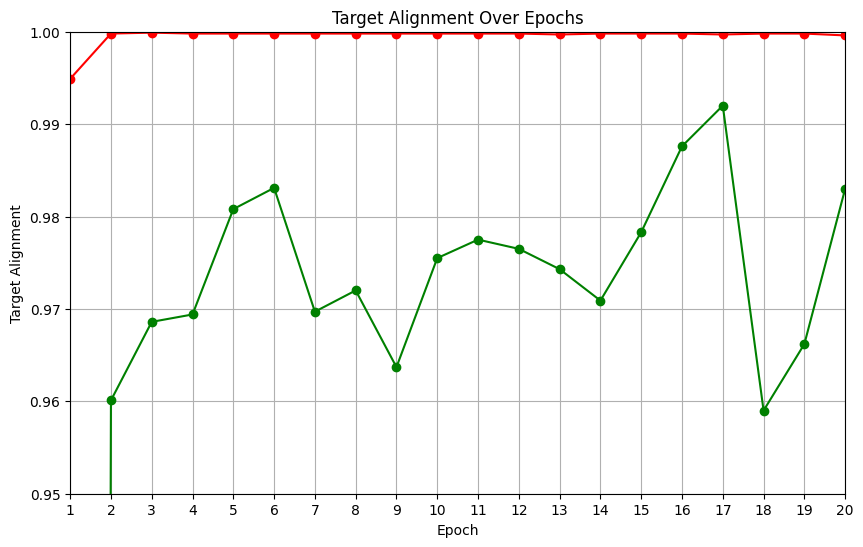

In [32]:
import matplotlib.pyplot as plt

# Example data
epochs = list(range(1, 21))  # Assuming 20 epochs


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, average_cosine_similarity_values_back_propagation, marker='o', linestyle='-', color='g', label='Backpropagation')
plt.plot(epochs, average_cosine_similarity_values_predictive_coding, marker='o', linestyle='-', color='r', label='Predictive Coding')
plt.xlabel('Epoch')
plt.ylabel('Target Alignment')
plt.ylim(0.95, 1.0)
plt.xlim(1, 20)
plt.title('Target Alignment Over Epochs')
plt.grid(True)
plt.xticks(epochs)  # This ensures all epochs are marked on the x-axis
plt.show()